<a href="https://colab.research.google.com/github/lauraredmondson/nma-eggplant-cobra/blob/master/our_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import modules

import keras
from keras import layers
from keras.applications import ResNet152V2, VGG16, VGG19
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
import urllib

Using TensorFlow backend.


In [ ]:
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)  


In [ ]:
# import labels

temp_test, _ = urllib.request.urlretrieve('https://github.com/lauraredmondson/nma-eggplant-cobra/raw/master/y_test.mat')
temp_train,  _ = urllib.request.urlretrieve('https://github.com/lauraredmondson/nma-eggplant-cobra/raw/master/y_train.mat')
test = loadmat(temp_test)
train = loadmat(temp_train)
print(train.keys())

In [ ]:
test = loadmat('y_test.mat')
train = loadmat('y_train.mat')

In [ ]:
# extract variables

y_train = train["y_train"]
y_test = test["y_test"]
print(np.max(y_train))
x_train = dat["stimuli"]
x_test = dat["stimuli_test"]

8


In [ ]:
# Preprocessing

# subtract mean, divide by standard deviation, add axis 
# one-hot array 

x_train= x_train.astype('float32')   #currently X matrices are of data type int: need to convert here to stop python from complaining when we divide
x_train -= np.mean(x_train)           #deduct the mean: now mean == 0
x_train /= np.std(x_train)            #divide by the std: now std == 1
x_train = np.expand_dims(x_train, -1) #add an extra dimension because our Conv2D layer wills it so

x_test = x_test.astype('float32')     #see above
x_test -= np.mean(x_test)
x_test /= np.std(x_test)
x_test = np.expand_dims(x_test, -1)

x_train = np.tile(x_train, 3)
x_test = np.tile(x_test, 3)

y_train -= 1
y_test -= 1

y_train = keras.utils.to_categorical(y_train, 8) #turn our y vectors (currently ints 0-9) into 'one-hot' vectors to match the categorical output of our network
y_test = keras.utils.to_categorical(y_test, 8)

In [ ]:
# Our base, see https://arxiv.org/abs/1409.1556 for details
conv_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3),
)

print(conv_base.summary())
conv_base.trainable = False # Freeze!

80142336/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [ ]:
# Now we make a model and stick a head on it
model = keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 20,844,492
Trainable params: 820,108
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
#datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(x_train)
# fits the model on batches with real-time data augmentation:
#history=model.fit(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch=len(x_train) / 50, epochs=10)
# uncomment out the above and comment the line below if you want to run the training with data augmentation instead (Which to me doesn)
history=model.fit(x_train, y_train, batch_size=50, epochs=10,validation_split=0.1)

Train on 1575 samples, validate on 175 samples
Epoch 1/10
1575/1575 [==============================] - 14s 9ms/step - loss: 1.4464 - accuracy: 0.5213 - val_loss: 1.0279 - val_accuracy: 0.6571
Epoch 2/10
1575/1575 [==============================] - 4s 2ms/step - loss: 0.7032 - accuracy: 0.7581 - val_loss: 0.9018 - val_accuracy: 0.6686
Epoch 3/10
1575/1575 [==============================] - 4s 2ms/step - loss: 0.4812 - accuracy: 0.8495 - val_loss: 0.9382 - val_accuracy: 0.6857
Epoch 4/10
1575/1575 [==============================] - 4s 2ms/step - loss: 0.3168 - accuracy: 0.9105 - val_loss: 0.9401 - val_accuracy: 0.6971
Epoch 5/10
1575/1575 [==============================] - 4s 2ms/step - loss: 0.2416 - accuracy: 0.9416 - val_loss: 1.0084 - val_accuracy: 0.6914
Epoch 6/10
1575/1575 [==============================] - 4s 2ms/step - loss: 0.1509 - accuracy: 0.9727 - val_loss: 0.9140 - val_accuracy: 0.6971
Epoch 7/10
1575/1575 [==============================] - 4s 2ms/step - loss: 0.1053 - acc

120/120 [==============================] - 3s 23ms/step
Test loss: 0.8553064525127411
Test accuracy: 0.7916666865348816


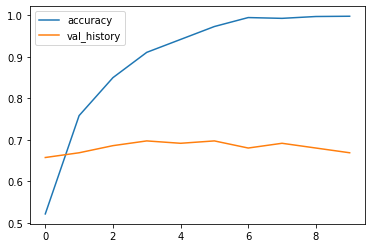

In [ ]:
# test

score = model.evaluate(x_test, y_test) # generates predictions and compares them with ground truth test_y all in one easy step!
print("Test loss:", score[0])
print("Test accuracy:", score[1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_history'])